### 05. 소프트맥스 회귀로 MNIST 데이터 분류하기

#### 1. MNIST 데이터 이해하기
- MNIST는 숫자 0부터 9까지의 이미지로 구성된 손글씨 데이터셋이다.
    - 이 데이터는 과거에 우체국에서 편지의 우편 번호를 인식하기 위해서 만들어진 훈련데이터이다.
    - 총 60000개의 훈련 데이터와 레이블, 총 10000개의 테스트 데이터와 레이블로 구성되어져 있다.
    - 레이블은 0부터 9까지 총 10개이다.
- MNIST 문제는 손글씨로 적힌 숫자 이미지가 들어오면 그 이미지가 무슨 숫자인지 맞추는 문제이다.

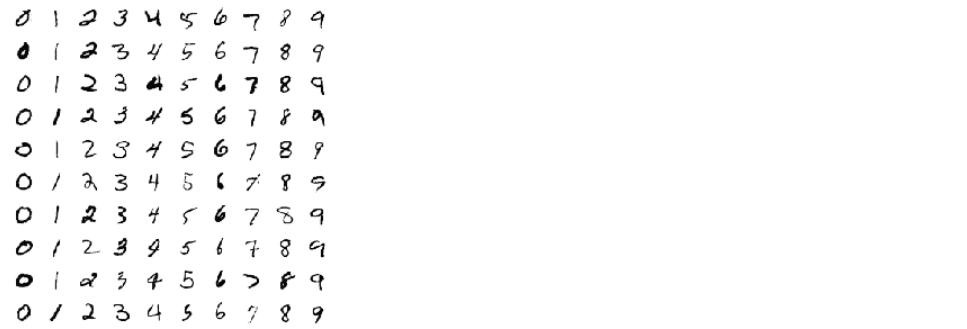

In [1]:
from IPython.display import Image
Image("mnist1.PNG")

각각의 이미지는 아래와 같이 28픽셀 x 28픽셀의 이미지

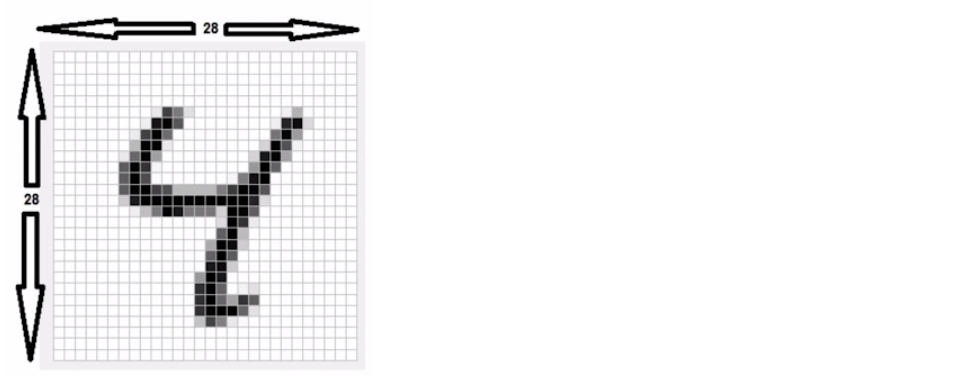

In [3]:
Image("mnist2.PNG")

- 이 문제를 풀기 위해 여기서는 28픽셀x28픽셀=784픽셀 이므로, 각 이미지를 총 784의 원소를 가진 벡터로 만든다.
- 이렇게 되면 총 784개의 특성을 가진 샘플이 되는데, 앞서 풀었던 어떤 문제들보다 특성이 굉장히 많은 샘플이다.

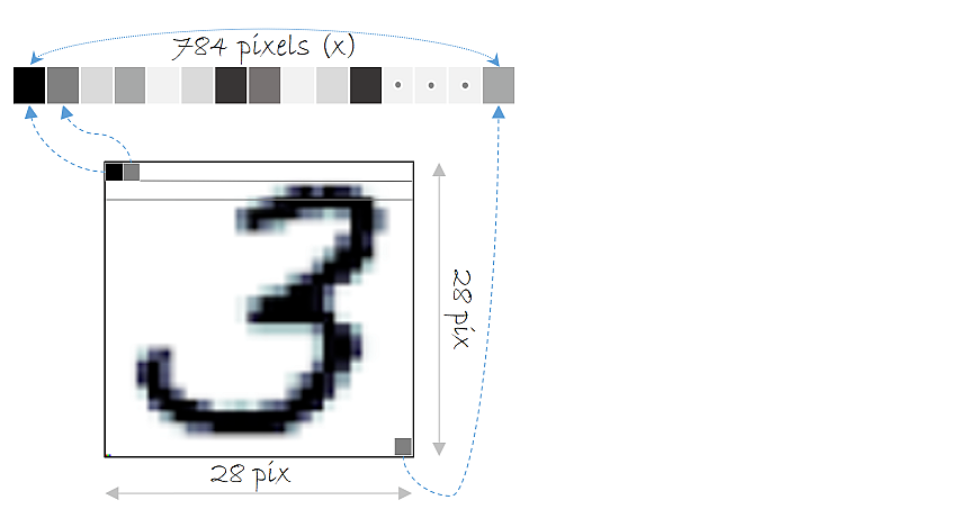

In [4]:
Image("mnist3.PNG")

784차원의 벡터로 만드는 코드

In [ ]:
for X, Y in data_loader : 
    # 입력 이미지를 [batch_size x 784]의 크기로 reshape
    # 레이블은 원-핫 인코딩
    X = X.view(-1, 28*28)

----------------------------------------------------------------------------------------------------------

#### 2.토치비전(torchvision)소개하기
- 유명한 데이터셋들, 이미 구현되어져 있는 유명한 모델들, 일반적인 전처리 도구들을 포함하고 있는 패키지
- 자연어 처리를 위해서는 토치텍스트라는 패키지도 있다.

----------------------------------------------------------------------------------------------------------

#### 3. 분류기 구현을 위한 사전 설정

In [7]:
import torch
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
import random

In [9]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("다음 기기로 학습합니다.", device)

다음 기기로 학습합니다. cpu


랜덤 시드 고정

In [12]:
# for reproducibility
random.seed(777)
torch.manual_seed(777)
if device == 'cuda' : 
    torch.cuda.manual_seed_all(777)

하이퍼파라미터를 변수로 둔다.

In [13]:
# hyperparameters
training_epochs = 15
batch_size = 100

----------------------------------------------------------------------------------------------------------

#### 4. MNIST 분류기 구현하기
- torchvision.datasets.dsets.MNIST를 사용하여 데이터셋을 불러올 수 있다.

In [15]:
# MNIST dataset
mnist_train = dsets.MNIST(root='MNIST_data/',
                          train=True,
                          transform=transforms.ToTensor(),
                          download=True)
mnist_test = dsets.MNIST(root='MNIST_data/',
                         train=False,
                         transform=transforms.ToTensor(),
                         download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST\raw\train-images-idx3-ubyte.gz to MNIST_data/MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST\raw\train-labels-idx1-ubyte.gz to MNIST_data/MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST\raw\t10k-images-idx3-ubyte.gz to MNIST_data/MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST_data/MNIST\raw\t10k-labels-idx1-ubyte.gz to MNIST_data/MNIST\raw



- 첫번째 인자 root : MNIST 데이터를 다운로드 받을 경로
- 두번째 인자 train : True(훈련 데이터를 리턴받는다.), False(테스트 데이터를 리턴받는다.)
- 세번째 인자 transform : 현재 데이터를 파이토치 텐서로 변환
- 네번째 인자 download : 해당 경로에 MNIST 데이터가 없다면 다운로드를 받겠다는 의미

앞서 미니 배치와 데이터로드 챕터에서 학습했던 데이터로드를 사용

In [37]:
print(len(mnist_train))
print(len(mnist_test))

60000
10000


In [20]:
# data loader
data_loader = DataLoader(dataset=mnist_train,
                         batch_size=batch_size,
                         shuffle=True,
                         drop_last=True)

- 첫번째 인자 dataset : 로드할 대상
- 두번째 인자 batch_size : 배치 크기
- 세번째 인자 shuffle : 매 에포크마다 미니 배치를 셔플할 것인지의 여부
- 네번째 인자 drop_last : 마지막 배치를 버릴 것인지를 의미
    - drop_last를 하는 이유
        - 1000개의 데이터가 있다고 할 때 비치 크기가 128이라고 가정
        - 1000을 128로 나누면 총 7개가 나오고 나머지로 104개가 남는다. 이때 마지막 배치로 한다고 하였을 때 128개를 충족하지 못하였으므로 104개를 그냥 버릴 수도 있다.
        - 마지막 배치를 버리려면 drop_last = True로 설정한다. 이는 다른 미니 배치보다 개수가 적은 마지막 배치를 경사 하강법에 사용하여 마지막 배치가 상대적으로 과대평가되는 현상을 막아준다. 

모델 설계 
- input_dim은 784, output_dim은 10
- to()함수는 연산을 어디서 수행할지를 정한다. 
    - 모델의 매개변수를 지정한 장치의 메모리로 보낸다.
    - CPU를 사용할 경우에는 필요가 없지만, GPU를 사용하려면 to('cuda')를 해 줄 필요가 있다.
- bias는 편향 b를 사용할 것인지를 나타낸다. 

In [24]:
# MNIST data image of shape 28*28 = 784
linear = nn.Linear(784, 10, bias=True).to(device)

In [25]:
# 비용함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss().to(device) # 내부적으로 소프트맥스 함수를 포함하고 있음
optimizer = torch.optim.SGD(linear.parameters(), lr=0.1)

In [31]:
print(len(data_loader))

600


- 앞서 torch.nn.functional.cross_entropy()를 사용하였으나 여기서는 torch.nn.CrossEntropyLoss()를 사용한다. 둘 다 파이토치에서 제공하는 크로스 엔트로피 함수로 둘 다 소프트맥스 함수를 포함하고 있다.

In [38]:
for epoch in range(training_epochs) : 
    avg_cost = 0
    total_batch = len(data_loader)
    
    for X, Y in data_loader : 
        # 배치 크기가 100이므로 아래의 연산에서 X는 (100, 784)의 텐서가 된다.
        X = X.view(-1, 28*28).to(device)
        # 레이블은 원-핫 인코딩이 된 상태가 아니라 0~9의 정수
        Y = Y.to(device)
        
        optimizer.zero_grad()
        hypothesis = linear(X)
        cost = criterion(hypothesis, Y)
        cost.backward()
        optimizer.step()
        
        avg_cost += cost / total_batch
        
    print('Epoch : ', '%04d' % (epoch+1), 'cost=', '{:.9f}'.format(avg_cost))
print('Learning finished')

Epoch :  0001 cost= 0.536714792
Epoch :  0002 cost= 0.359240860
Epoch :  0003 cost= 0.331269383
Epoch :  0004 cost= 0.316709459
Epoch :  0005 cost= 0.307221323
Epoch :  0006 cost= 0.300298899
Epoch :  0007 cost= 0.295184374
Epoch :  0008 cost= 0.290932894
Epoch :  0009 cost= 0.287400424
Epoch :  0010 cost= 0.284594446
Epoch :  0011 cost= 0.282061309
Epoch :  0012 cost= 0.279854059
Epoch :  0013 cost= 0.278027594
Epoch :  0014 cost= 0.276101291
Epoch :  0015 cost= 0.274421781
Learning finished


Accuracy: 0.8870000243186951
Label :  9
Prediction :  9


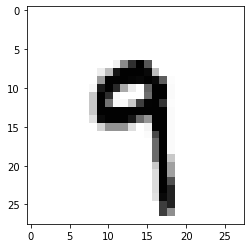

In [58]:
# 테스트 데이터를 사용하여 모델 테스트
with torch.no_grad() : # torch..no_grad()를 하면 gradient 계산을 수행하지 않는다.
    X_test = mnist_test.test_data.view(-1, 28*28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)
    
    prediction = linear(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())
    
    # MNIST 테스트 데이터에서 무작위로 하나를 뽑아서 예측
    r = random.randint(0, len(mnist_test) -1)
    X_single_data = mnist_test.test_data[r:r+1].view(-1, 28*28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r+1].to(device)
    
    print('Label : ', Y_single_data.item())
    single_prediction = linear(X_single_data)
    print('Prediction : ', torch.argmax(single_prediction, 1).item())
    
    plt.imshow(mnist_test.test_data[r:r+1].view(28, 28), cmap='Greys', interpolation='nearest')
    plt.show()

In [40]:
prediction

tensor([[  274.5121, -2489.0249,   279.0018,  ...,  2502.4192,   415.2830,
           797.9315],
        [ 1349.2382,  -279.4633,  2689.8467,  ..., -4231.3770,  1518.2163,
         -2218.1296],
        [-1383.4746,  1514.9696,   476.4080,  ...,   -22.9976,   580.8383,
          -317.1317],
        ...,
        [-1795.3213, -1880.6854,  -643.3528,  ...,   276.8374,  1395.0211,
          1212.6522],
        [ -395.7306,  -444.8710,  -481.8023,  ..., -1426.8917,  1672.7275,
          -699.6245],
        [ 1061.0483, -2740.0803,  1356.8960,  ..., -2227.3652,   392.7957,
          -981.4744]])

In [80]:
print('Label : ', Y_single_data.item())

Label :  9


In [67]:
mnist_test.test_labels.shape

torch.Size([10000])

In [68]:
print(mnist_test.test_labels)

tensor([7, 2, 1,  ..., 4, 5, 6])


In [69]:
print(len(mnist_test))

10000
